In [1]:
%load_ext autoreload
%autoreload 2

In [ ]:
import torch

from torch import nn
from torch.utils.data import DataLoader
import sys

from collections import defaultdict
import numpy as np

import pandas as pd

from src.data.movielens import MovieLensDataset
from src.data.utils import split_train_test_by_ts

from src.utils import random_seed

from src.models.movielens import RecommendationSystemModel

from src.measures import (
    plot_loss_per_group,
    get_mean_utility_at_k,
    plot_user_utility_per_group,
    calculate_precision_recall,
)

ModuleNotFoundError: No module named 'src.data'

In [5]:
from torch.utils.data import Dataset
from pathlib import Path
import pandas as pd

In [26]:
root_path = Path("../data/ml-100k")

data_df = pd.read_csv(root_path / "u.data", sep="\t", header=None, names=["user_id", "item_id", "rating", "timestamp"])
genres_df = pd.read_csv(root_path / "u.genre", sep="|", header=None, encoding="latin-1", names=["genre", "id"])
movies_df = pd.read_csv(root_path / "u.item", sep="|", header=None, encoding="latin-1", names=["item_id", "title", "release_date", "empty", "link"] + list(genres_df["genre"]))

In [27]:
# assign one random genre to each movie from the list of genres (which is a one-hot encoding)
genre_titles = genres_df["genre"].values
for i, row in movies_df.iterrows():
    genres = row[5:].values
    genres = np.where(genres == 1)[0]
    if len(genres) > 0:
        movies_df.at[i, "genre"] = genre_titles[np.random.choice(genres)]
    else:
        movies_df.at[i, "genre"] = -1

In [33]:
movies_df = movies_df[["item_id", "genre"]]

In [38]:
data_df["label"] = data_df["rating"].apply(lambda x: 1 if x > 3 else 0)

In [45]:
movies_df

,item_id,genre
0,1,Children's
1,2,Adventure
2,3,Thriller
3,4,Drama
4,5,Drama
...,...,...
1677,1678,Drama
1678,1679,Romance
1679,1680,Drama
1680,1681,Comedy


In [44]:
data_df

,user_id,item_id,rating,timestamp,label
0,196,242,3,881250949,0
1,186,302,3,891717742,0
2,22,377,1,878887116,0
3,244,51,2,880606923,0
4,166,346,1,886397596,0
...,...,...,...,...,...
99995,880,476,3,880175444,0
99996,716,204,5,879795543,1
99997,276,1090,1,874795795,0
99998,13,225,2,882399156,0


In [50]:
data_df = data_df.merge(movies_df, on="item_id", how="left")

In [87]:
# get top genre for each user
def get_top_genre_per_user(data_df):

    # Group by user_id and genre, and count the number of ratings for each genre
    genre_counts = data_df.groupby(["user_id", "genre"]).size().reset_index(name="count")

    # Get the top genre for each user
    top_genre = genre_counts.loc[genre_counts.groupby("user_id")["count"].idxmax()]

    return top_genre[["user_id", "genre"]].reset_index(drop=True)

def get_usage_category_per_user(data_df):
    # 2 std below mean is low; 2 std above mean is high the rest is medium
    # get usage by the number of rated items per user
    usage_counts = data_df.groupby("user_id").size().reset_index(name="count")
    print("min usage count: ", usage_counts["count"].min())
    mean = usage_counts["count"].mean()
    std = usage_counts["count"].std()
    usage_counts["usage"] = "medium"
    print(f"mean: {mean}, std: {std}")
    print(mean - std)
    usage_counts.loc[usage_counts["count"] < mean, "usage"] = "low"
    usage_counts.loc[usage_counts["count"] > mean + 2 * std, "usage"] = "high"

    return usage_counts[["user_id", "usage"]].reset_index(drop=True)


top_genre_df = get_top_genre_per_user(data_df)
usage_df = get_usage_category_per_user(data_df)

min usage count:  20
mean: 106.04453870625663, std: 100.93174276633498
5.112795939921654


In [93]:
users_df = top_genre_df.merge(usage_df, on="user_id", how="left")
users_df

,user_id,genre,usage
0,1,Drama,medium
1,2,Drama,low
2,3,Drama,low
3,4,Drama,low
4,5,Comedy,medium
...,...,...,...
938,939,Comedy,low
939,940,Drama,medium
940,941,Drama,low
941,942,Drama,low


In [97]:
res = []
users_df = top_genre_df.merge(usage_df, on="user_id", how="left")
for i, row in users_df.iterrows():
    res.append(
        {
            "user_id": row["user_id"] - 1,
            "usage_group": row["usage"],
            "top_category": row["genre"],
        }
    )
res


import json
with open("movielens_user_groups.json", "w") as f:
    json.dump(res, f)

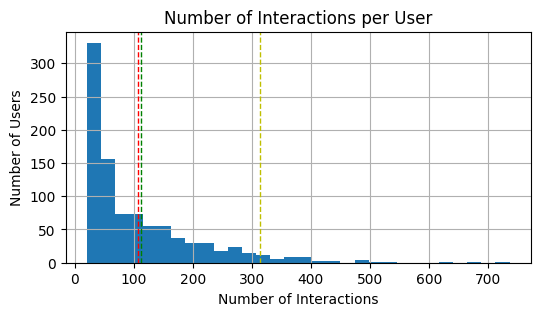

In [74]:
import matplotlib.pyplot as plt

user_interactions = data_df.groupby("user_id").count()
interactions_count = user_interactions["item_id"]

mean = interactions_count.mean()
std = interactions_count.std()

higher_bound = mean * 2 + std
lower_bound = mean * 2 - std

plt.figure(figsize=(6, 3), dpi=100)
interactions_count.hist(bins=30)
plt.xlabel("Number of Interactions")
plt.ylabel("Number of Users")

plt.axvline(mean, color='r', linestyle='dashed', linewidth=1)
plt.axvline(lower_bound, color='g', linestyle='dashed', linewidth=1)
plt.axvline(higher_bound, color='y', linestyle='dashed', linewidth=1)

plt.title("Number of Interactions per User")
plt.show()

In [ ]:
class MovieLensDatase(Dataset):
    def __init__(self, root_dir: Path):
        self.data = data
        self.user_col = user_col
        self.item_col = item_col
        self.rating_col = rating_col

    def __len__(self):
        return len(self.data)

    def _load_data(self, root_dir: Path):
        root_data = pd.read_csv(root_path / "u.data", sep="\t", header=None, names=["user_id", "item_id", "rating", "timestamp"])
        genres


    def __getitem__(self, idx):
        row = self.data.iloc[idx]
        return {
            'user': row[self.user_col],
            'item': row[self.item_col],
            'rating': row[self.rating_col]
        }

In [3]:
random_seed(0)

In [4]:
# load data
df = MovieLensDataset(download=True)._data
# remove Unknown genre
df = df[df.genre != "Unknown"]
# remove users with less than 10 ratings
df = df.groupby("user_id").filter(lambda x: len(x) >= 10)

USERS_COUNT = df.user_id.nunique()
ITEMS_COUNT = df.item_id.nunique()

df["user_id"] = df["user_id"].astype("category").cat.codes.values
df["item_id"] = df["item_id"].astype("category").cat.codes.values

train_df, test_df = split_train_test_by_ts(df, ts_col="timestamp", entity_col="user_id", test_size=0.2)

In [5]:
BATCH_SIZE = 32

train_dataset = MovieLensDataset(data=train_df)
test_dataset = MovieLensDataset(data=test_df)

train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [6]:
EPOCHS = 2

loss_func = nn.BCEWithLogitsLoss()

recommendation_model = RecommendationSystemModel(
    num_users=USERS_COUNT,
    num_movies=ITEMS_COUNT,
    embedding_size=128,
    hidden_dim=256,
    dropout_rate=0.1,
).to(device)

optimizer = torch.optim.Adam(recommendation_model.parameters(), lr=1e-3)


# Function to log progress
def log_progress(epoch, step, total_loss, log_progress_step, data_size, losses):
    avg_loss = total_loss / log_progress_step
    sys.stderr.write(
        f"\r{epoch + 1:02d}/{EPOCHS:02d} | Step: {step}/{data_size} | Avg Loss: {avg_loss:<6.9f}"
    )
    sys.stderr.flush()
    losses.append(avg_loss)


total_loss = 0
log_progress_step = 100
losses = []
train_dataset_size = len(train_dataset)
print(f"Training on {train_dataset_size} samples...")

recommendation_model.train()
for e in range(EPOCHS):
    step_count = 0  # Reset step count at the beginning of each epoch
    for i, train_data in enumerate(train_loader):
        output = recommendation_model(train_data["users"].to(device), train_data["items"].to(device))
        # Reshape the model output to match the target's shape
        output = output.squeeze()  # Removes the singleton dimension
        ratings = train_data["labels"].to(device)  # Assuming ratings is already 1D

        mask = train_data["genre_mask"].to(device)

        loss = loss_func(output, ratings)
        total_loss += loss.sum().item()
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        # Increment step count by the actual size of the batch
        step_count += len(train_data["users"])

        # Check if it's time to log progress
        if step_count % log_progress_step == 0 or i == len(train_loader) - 1:  # Log at the end of each epoch
            log_progress(e, step_count, total_loss, log_progress_step, train_dataset_size, losses)
            total_loss = 0

01/02 | Step: 800/80359 | Avg Loss: 0.134178385

Training on 80359 samples...


02/02 | Step: 80359/80359 | Avg Loss: 0.048617758

In [10]:
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False)

predictions, targets = recommendation_model.predict(test_loader, device)
test_df["probs"] = 1 / (1 + np.exp(-predictions))

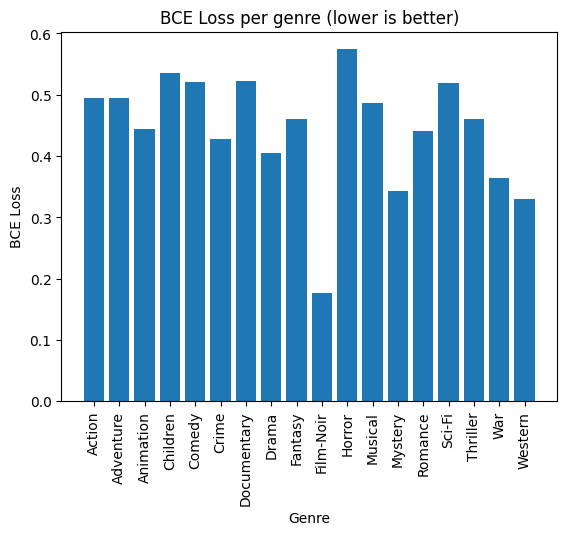

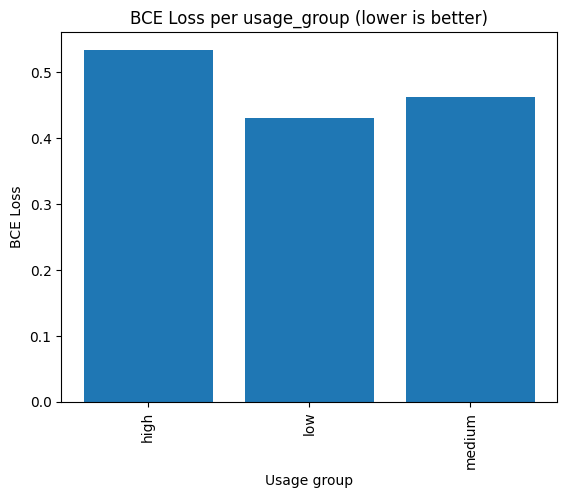

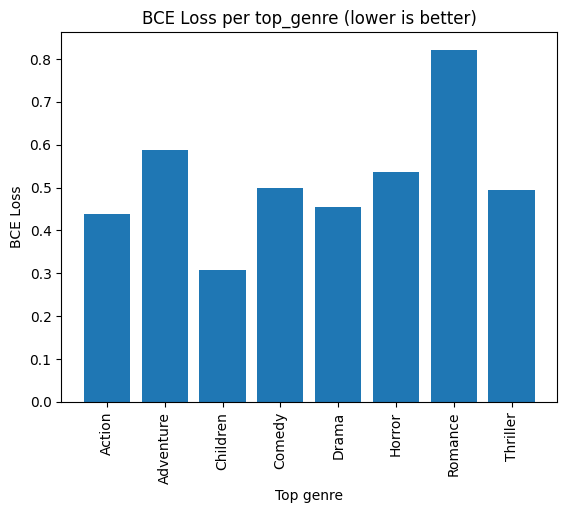

In [14]:
plot_loss_per_group(test_df, "genre")
plot_loss_per_group(test_df, "usage_group")
plot_loss_per_group(test_df, "top_genre")

Mean utility at k=5: 0.890


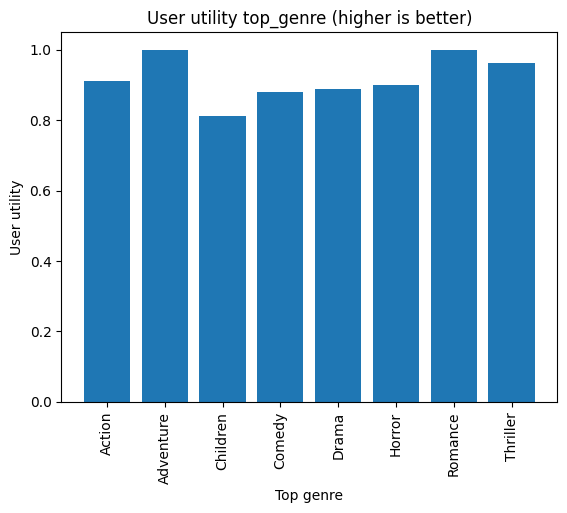

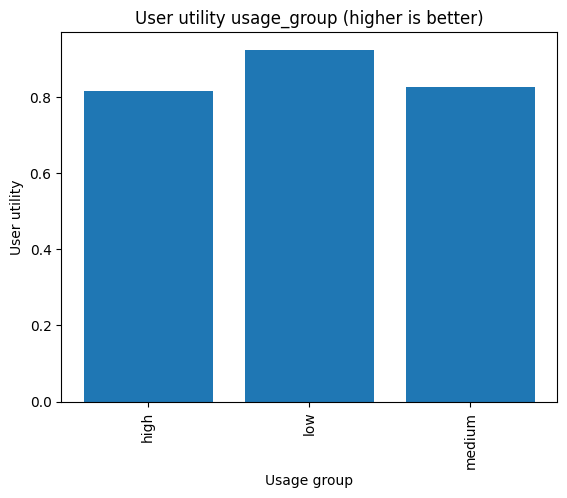

In [ ]:
k = 5
print(f"Mean utility at k={k}: {get_mean_utility_at_k(test_df, k):.3f}")

plot_user_utility_per_group(test_df, "top_genre", k)
plot_user_utility_per_group(test_df, "usage_group", k)

In [17]:
user_ratings_comparison = defaultdict(list)

with torch.no_grad():
    for valid_data in test_loader:
        users = valid_data["users"].to(device)
        movies = valid_data["items"].to(device)
        ratings = valid_data["ratings"].to(device)
        output = recommendation_model(users, movies)

        for user, pred, true in zip(users, output, ratings):
            user_ratings_comparison[user.item()].append((pred[0].item(), true.item()))

user_precisions = dict()
user_based_recalls = dict()

k = 50
threshold = 3

for user_id, user_ratings in user_ratings_comparison.items():
    precision, recall = calculate_precision_recall(user_ratings, k, threshold)
    user_precisions[user_id] = precision
    user_based_recalls[user_id] = recall


average_precision = sum(prec for prec in user_precisions.values()) / len(user_precisions)
average_recall = sum(rec for rec in user_based_recalls.values()) / len(user_based_recalls)

print(f"precision @ {k}: {average_precision:.4f}")
print(f"recall @ {k}: {average_recall:.4f}")

precision @ 50: 0.9741
recall @ 50: 0.1665


In [18]:
# create new df of movies each user never rated
users = df.user_id.unique()
movies = df.item_id.unique()
user_movie = []
for user in users:
    for movie in movies:
        if movie not in df[df.user_id == user].item_id.values:
            user_movie.append({"user_id": user, "item_id": movie})

movies_df = pd.DataFrame(user_movie)
movies_df["genre"] = "Unknown"
movies_df["rating"] = 0
movies_loader = DataLoader(MovieLensDataset(data=movies_df), batch_size=BATCH_SIZE, shuffle=False)

predictions, targets = recommendation_model.predict(movies_loader, device)
movies_df["predictions"] = predictions
movies_df["probs"] = movies_df["predictions"].apply(lambda x: 1 / (1 + np.exp(-x)))

In [ ]:
usage_groups = train_df.groupby("user_id")["usage_group"].first().reset_index()
top_genres = train_df.groupby("user_id")["top_genre"].first().reset_index()

user_groups = pd.merge(usage_groups, top_genres, on="user_id")

user_groups.sort_values("user_id", inplace=True)
user_groups.to_json("user_groups.json", orient="records")

In [33]:
# export predictions

movies_df.sort_values(by=["user_id"], ascending=True, inplace=True)
user_movie_matrix = movies_df.pivot_table(index="user_id", columns="item_id", values="probs", fill_value=0.2)
user_movie_matrix.reset_index(inplace=True, drop=True)

with open("predictions.npy", "wb") as f:
    np.save(f, user_movie_matrix.to_numpy())